In [44]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib
from medpy.metric.binary import dc
from tqdm import tqdm
from numpy import genfromtxt
import pandas as pd
import scipy

# The Model we use

In [45]:
loss = genfromtxt('./models/v2/loss.csv', delimiter=',')

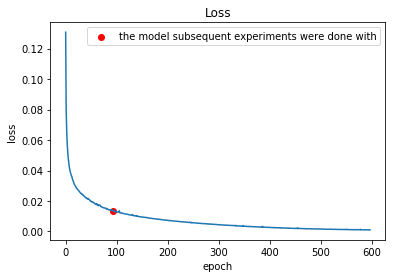

In [46]:
plt.plot(loss[1:,1])
plt.scatter(93,loss[93,1], c='r', label = 'the model subsequent experiments were done with')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [47]:
gt_base_path = '/Users/ariox/Study/ML/SkolBrainet/for_Ilya/data/'
pred_base_path = '/Users/ariox/Study/ML/SkolBrainet/for_Ilya/pred/'
print(os.listdir(pred_base_path))

['test_predict_CC0001_philips_15_55_M.npy']


In [48]:
path = pred_base_path + os.listdir(pred_base_path)[0]
test = np.load(path)

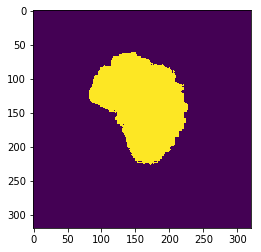

In [49]:
plt.imshow(test[100,:,:])

# Dice scores

In [50]:
pred = {}
for name in os.listdir(pred_base_path):
    scan_N = int(name.split('_')[2][2:])
    path = pred_base_path + name  
    file = np.load(path)
    pred[scan_N] = file

In [51]:
gt = {}
crop_size = 65
padding = crop_size // 2
pad = ((padding, padding), (padding, padding), (padding, padding))
imgsPredicted = list(pred.keys())
for name in tqdm(os.listdir(gt_base_path)):
    scan_N = int(name.split('_')[0][2:])
    if scan_N in imgsPredicted:
        path = gt_base_path + name  
        img = nib.load(path)
        data = img.get_fdata()
        padded_gt = np.pad(data, pad)
        gt[scan_N] = padded_gt

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


In [52]:
dices = {}

In [53]:
for N in tqdm(imgsPredicted):
    dices[N] = dc(pred[N],gt[N])

100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


In [60]:
print(dices)

{1: 0.961856933687565}


In [54]:
dicesForDomains = {}
for name in os.listdir(pred_base_path):
    domain = name.split('_')[3] + name.split('_')[4]
    scan_N = int(name.split('_')[2][2:])
    if domain == 'siemens15':
        if scan_N >= 120 and scan_N <= 169:
            domain = domain +'_train'
        else:
            domain = domain +'_rest_of_the_domain'
    if domain in dicesForDomains.keys():
        dicesForDomains[domain].append([scan_N, dices[scan_N]])
    else:
        dicesForDomains[domain] = [[scan_N, dices[scan_N]]]

In [55]:
for key in dicesForDomains.keys():
    print(key, ':', len(dicesForDomains[key]), 'scans')

philips15 : 1 scans


In [57]:
domains_list = ['siemens15_train', 'siemens15_rest_of_the_domain','philips15', 'ge15', 'philips3', 'ge3']
avg_arr = []
std_arr = []
number_scans = []

for key in domains_list: 
    avg = np.array(dicesForDomains[key])[:,1].mean()
    std = np.array(dicesForDomains[key])[:,1].std()
    print(key, ':', len(dicesForDomains[key]), 'scans; dice = ', round(avg,3), '+-', round(std,3)) 
    
    avg_arr.append(round(avg,3))
    std_arr.append(round(std,3))
    number_scans.append(len(dicesForDomains[key]))

KeyError: 'siemens15_train'

In [58]:
a = pd.DataFrame(np.array([avg_arr, std_arr, number_scans]),
                   columns=domains_list)
a = a.T
a.columns = ['dice','std','number_of_scans']
a.number_of_scans = a.number_of_scans.astype(int)

AssertionError: Number of manager items must equal union of block items
# manager items: 6, # tot_items: 0

In [113]:
a

,dice,std,number_of_scans
siemens15_train,0.973,0.004,50
siemens15_rest_of_the_domain,0.973,0.003,10
philips15,0.962,0.000,1
ge15,0.955,0.011,60
philips3,0.950,0.020,55
ge3,0.947,0.033,60


# Surface-Dice

In [91]:
import surfacedistance.surface_distance.metrics as surf_dc

surf_dices = {}
for N in tqdm(imgsPredicted):
    surf_dices[N] = surf_dc.compute_surface_distances(pred[N],gt[N], spacing_mm=(1, 1, 1))

print(surf_dices)

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

{1: {'distances_gt_to_pred': array([ 0.        ,  0.        ,  0.        , ..., 19.87460691,
       20.1246118 , 20.4450483 ]), 'distances_pred_to_gt': array([ 0.        ,  0.        ,  0.        , ..., 15.32970972,
       15.5241747 , 15.55634919]), 'surfel_areas_gt': array([0.21650635, 0.21650635, 0.21650635, ..., 0.21650635, 0.21650635,
       0.21650635]), 'surfel_areas_pred': array([0.21650635, 0.21650635, 0.21650635, ..., 0.21650635, 0.70710678,
       0.21650635])}}


# Rescaling all the images

In [1]:
def resample(image, mask, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing
    spacing = image.header['pixdim'][1:4]  # map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    print('spacing', spacing)
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    ### These 3 lines are actually rebundant (scipy can round itself)
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    ###
    image = scipy.ndimage.interpolation.zoom(image.get_fdata(), real_resize_factor, order=3)
    mask = scipy.ndimage.interpolation.zoom(mask.get_fdata(), real_resize_factor, order=0)
    return image, mask

In [40]:
orig_base_path = '../Original/'
gt_base_path = '../Silver-standard-ML/'

orig_base_path_sc = '../originalScaled/'
gt_base_path_sc = '../Silver-standard-MLScaled/'

In [41]:
names_orig = os.listdir(orig_base_path)
names_orig.sort()

names_gt = os.listdir(gt_base_path)
names_gt.sort()

## Prototyping

In [48]:
or1 = nib.load(orig_base_path + names_orig[1])
gt1 = nib.load(gt_base_path + names_gt[1])

In [53]:
image, mask = resample(or1, gt1)

spacing [1.        0.8888889 0.8888889]


In [54]:
image.shape

(150, 256, 256)

In [55]:
or1.get_fdata().shape

(150, 288, 288)

In [59]:
np.save(orig_base_path_sc + "foo", image)

## Actual rescaling

In [ ]:
for name_orig, name_gt in tqdm(zip(names_orig, names_gt)):
    #loading the images
    orig = nib.load(orig_base_path + name_orig)
    gt = nib.load(gt_base_path + name_gt)
    #resampling
    image, mask = resample(orig, gt)
    #saving
    np.save(orig_base_path_sc + name_orig[:-7], image)
    np.save(gt_base_path_sc + name_gt[:-7], mask)

0it [00:00, ?it/s]

spacing [0.9999982 1.        1.       ]


1it [00:05,  5.54s/it]

spacing [1.        0.8888889 0.8888889]


2it [00:10,  5.44s/it]

spacing [1.0000049 0.8888889 0.8888889]


3it [00:16,  5.39s/it]

spacing [1.0000103 0.8888889 0.8888889]


4it [00:20,  5.19s/it]

spacing [1.0000097 0.8888889 0.8888889]


5it [00:25,  5.15s/it]

spacing [1.0000039 0.8888889 0.8888889]


6it [00:30,  4.92s/it]

spacing [0.99999857 0.8888889  0.8888889 ]


7it [00:34,  4.82s/it]

spacing [1.0000079 0.8888889 0.8888889]


8it [00:39,  4.83s/it]

spacing [0.9999985 0.8888889 0.8888889]


9it [00:45,  5.07s/it]

spacing [0.99999523 0.8888889  0.8888889 ]


10it [00:49,  4.85s/it]

spacing [0.9999991 0.8888889 0.8888889]


11it [00:54,  4.73s/it]

spacing [0.9999984 0.8888889 0.8888889]


12it [00:59,  4.82s/it]

spacing [1.0000117 0.8888889 0.8888889]


13it [01:03,  4.60s/it]

spacing [1.0000054 0.8888889 0.8888889]


14it [01:07,  4.47s/it]

spacing [1.0000031 0.8888889 0.8888889]


15it [01:11,  4.38s/it]

spacing [0.9999893 0.8888889 0.8888889]


16it [01:17,  4.82s/it]

spacing [0.99999756 0.8888889  0.8888889 ]


17it [01:21,  4.60s/it]

spacing [0.999998  0.8888889 0.8888889]


18it [01:25,  4.45s/it]

spacing [0.9999957 0.8888889 0.8888889]


19it [01:29,  4.33s/it]

spacing [1.0000111 0.8888889 0.8888889]


20it [01:34,  4.59s/it]

spacing [1.0000063 0.8888889 0.8888889]


21it [01:38,  4.47s/it]

spacing [0.9999989 0.8888889 0.8888889]


22it [01:43,  4.58s/it]

spacing [0.99999523 0.8888889  0.8888889 ]


23it [01:48,  4.59s/it]

spacing [1.0000025 0.8888889 0.8888889]


24it [01:52,  4.58s/it]

spacing [1.0000083 0.8888889 0.8888889]


25it [01:58,  4.92s/it]

spacing [0.999993  0.8888889 0.8888889]


26it [02:04,  5.13s/it]

spacing [0.9999967 0.8888889 0.8888889]


27it [02:08,  4.89s/it]

spacing [0.99999744 0.8888889  0.8888889 ]


28it [02:12,  4.67s/it]

spacing [0.9999994 0.8888889 0.8888889]


29it [02:16,  4.49s/it]

spacing [1.0000085 0.8888889 0.8888889]


30it [02:20,  4.36s/it]

spacing [1.0000025 0.8888889 0.8888889]


31it [02:24,  4.27s/it]

spacing [1.0000108  0.95522386 0.95522386]


32it [02:29,  4.37s/it]

spacing [0.9999979 0.8888889 0.8888889]


33it [02:34,  4.65s/it]

spacing [0.99999005 0.8888889  0.8888889 ]


34it [02:39,  4.68s/it]

spacing [1.000005  0.8888889 0.8888889]


35it [02:43,  4.54s/it]

spacing [1.0000077 0.8888889 0.8888889]


36it [02:47,  4.43s/it]

spacing [0.9999989 0.8888889 0.8888889]


37it [02:52,  4.45s/it]

spacing [0.9999888 0.8888889 0.8888889]


38it [02:56,  4.34s/it]

spacing [0.9999867 0.8888889 0.8888889]


39it [03:00,  4.25s/it]

spacing [1.0000017 0.8888889 0.8888889]


40it [03:04,  4.20s/it]

spacing [1.0000005 0.8888889 0.8888889]


41it [03:09,  4.41s/it]

spacing [0.9999988 0.8888889 0.8888889]


42it [03:13,  4.29s/it]

spacing [0.99999213 0.8888889  0.8888889 ]


43it [03:17,  4.21s/it]

spacing [0.9999964 0.8888889 0.8888889]


44it [03:22,  4.35s/it]

spacing [1.0000082 0.8888889 0.8888889]


45it [03:26,  4.42s/it]

spacing [1.0000012 0.8888889 0.8888889]


46it [03:31,  4.40s/it]

spacing [1.0000044 0.9142857 0.9142857]


47it [03:35,  4.47s/it]

spacing [0.9999978 0.8888889 0.8888889]


48it [03:39,  4.35s/it]

spacing [0.99998933 0.8888889  0.8888889 ]


49it [03:44,  4.27s/it]

spacing [0.9999983 0.8888889 0.8888889]


50it [03:48,  4.26s/it]

spacing [1.0000081 0.8888889 0.8888889]


51it [03:52,  4.30s/it]

spacing [0.999995  0.8888889 0.8888889]


52it [03:57,  4.60s/it]

spacing [0.99998826 0.8888889  0.8888889 ]


53it [04:02,  4.53s/it]

spacing [1.000004   0.92753625 0.92753625]


54it [04:07,  4.64s/it]

spacing [1.0000105 0.8888889 0.8888889]


55it [04:11,  4.49s/it]

spacing [0.99999   0.8888889 0.8888889]


56it [04:15,  4.38s/it]

spacing [1.0000004 0.8888889 0.8888889]


57it [04:19,  4.27s/it]

spacing [0.99999785 0.8888889  0.8888889 ]


58it [04:23,  4.20s/it]

spacing [0.9999956 0.8888889 0.8888889]


59it [04:28,  4.30s/it]

spacing [1. 1. 1.]


60it [04:32,  4.24s/it]

spacing [1. 1. 1.]


61it [04:36,  4.21s/it]

spacing [1. 1. 1.]


62it [04:40,  4.16s/it]

spacing [1. 1. 1.]


63it [04:44,  4.14s/it]

spacing [1. 1. 1.]


64it [04:48,  4.13s/it]

spacing [1. 1. 1.]


65it [04:52,  4.12s/it]

spacing [1. 1. 1.]


66it [04:57,  4.26s/it]

spacing [1. 1. 1.]


67it [05:01,  4.20s/it]

spacing [1. 1. 1.]


68it [05:05,  4.17s/it]

spacing [1. 1. 1.]


69it [05:09,  4.15s/it]

spacing [1. 1. 1.]


70it [05:13,  4.14s/it]

spacing [1. 1. 1.]


71it [05:18,  4.26s/it]

spacing [1. 1. 1.]


72it [05:22,  4.22s/it]

spacing [1. 1. 1.]


73it [05:26,  4.20s/it]

spacing [1. 1. 1.]


74it [05:30,  4.16s/it]

spacing [1. 1. 1.]


75it [05:34,  4.23s/it]

spacing [1. 1. 1.]


76it [05:39,  4.21s/it]

spacing [1. 1. 1.]


77it [05:43,  4.17s/it]

spacing [1. 1. 1.]


78it [05:47,  4.15s/it]

spacing [1.         0.98214287 0.98214287]


79it [05:50,  3.94s/it]

spacing [1.         0.98214287 0.98214287]


80it [05:54,  3.86s/it]

spacing [1. 1. 1.]


81it [05:58,  3.93s/it]

spacing [1.         0.98214287 0.98214287]


82it [06:02,  3.88s/it]

spacing [1. 1. 1.]


83it [06:06,  3.95s/it]

spacing [1. 1. 1.]


84it [06:10,  4.01s/it]

spacing [1. 1. 1.]


85it [06:14,  4.04s/it]

spacing [1. 1. 1.]


86it [06:18,  4.08s/it]

spacing [1. 1. 1.]


87it [06:22,  4.09s/it]

spacing [1. 1. 1.]


88it [06:27,  4.11s/it]

spacing [1. 1. 1.]


89it [06:31,  4.11s/it]

spacing [1. 1. 1.]


90it [06:35,  4.12s/it]

spacing [1. 1. 1.]


91it [06:39,  4.12s/it]

spacing [1. 1. 1.]


92it [06:43,  4.13s/it]

spacing [1. 1. 1.]


93it [06:47,  4.19s/it]

spacing [1. 1. 1.]


94it [06:52,  4.21s/it]

spacing [1. 1. 1.]


95it [06:56,  4.18s/it]

spacing [1. 1. 1.]


96it [07:01,  4.36s/it]

spacing [1.         0.98214287 0.98214287]


97it [07:04,  4.09s/it]

spacing [1. 1. 1.]


98it [07:08,  4.09s/it]

spacing [1. 1. 1.]


99it [07:13,  4.23s/it]

spacing [1.         0.98214287 0.98214287]


100it [07:16,  4.02s/it]

spacing [1. 1. 1.]


101it [07:20,  4.04s/it]

spacing [1. 1. 1.]


102it [07:24,  4.06s/it]

spacing [1. 1. 1.]


103it [07:29,  4.08s/it]

spacing [1. 1. 1.]


104it [07:33,  4.10s/it]

spacing [1. 1. 1.]


105it [07:37,  4.27s/it]

spacing [1. 1. 1.]


106it [07:42,  4.26s/it]

spacing [1. 1. 1.]


107it [07:46,  4.31s/it]

spacing [1. 1. 1.]


108it [07:50,  4.26s/it]

spacing [1. 1. 1.]


109it [07:54,  4.24s/it]

spacing [1. 1. 1.]


110it [07:58,  4.22s/it]

spacing [1. 1. 1.]


111it [08:03,  4.18s/it]

spacing [1. 1. 1.]


112it [08:07,  4.24s/it]

spacing [1. 1. 1.]


113it [08:11,  4.20s/it]

spacing [1. 1. 1.]


114it [08:15,  4.17s/it]

spacing [1. 1. 1.]


115it [08:19,  4.16s/it]

spacing [1. 1. 1.]


116it [08:24,  4.19s/it]

spacing [1. 1. 1.]


117it [08:28,  4.16s/it]

spacing [1. 1. 1.]


118it [08:32,  4.17s/it]

spacing [1. 1. 1.]


119it [08:36,  4.15s/it]

spacing [0.99999845 1.         1.        ]


120it [08:42,  4.76s/it]

spacing [0.9999995 1.        1.       ]


121it [08:48,  4.97s/it]

spacing [1. 1. 1.]


122it [08:53,  5.15s/it]

spacing [0.99999684 1.         1.        ]


123it [08:59,  5.27s/it]

spacing [0.9999997 1.        1.       ]


124it [09:04,  5.38s/it]

spacing [0.99999446 1.         1.        ]


125it [09:10,  5.43s/it]

spacing [1. 1. 1.]


126it [09:16,  5.49s/it]

spacing [1. 1. 1.]


127it [09:21,  5.51s/it]

spacing [1. 1. 1.]


128it [09:27,  5.55s/it]

spacing [0.99999803 1.         1.        ]


129it [09:32,  5.56s/it]

spacing [0.9999962 1.        1.       ]


130it [09:38,  5.55s/it]

spacing [1. 1. 1.]


131it [09:43,  5.57s/it]

spacing [1. 1. 1.]


132it [09:49,  5.56s/it]

spacing [1.0000036 1.        1.       ]


133it [09:55,  5.63s/it]

spacing [1. 1. 1.]


134it [10:00,  5.58s/it]

spacing [1. 1. 1.]


135it [10:06,  5.57s/it]

spacing [1. 1. 1.]


136it [10:11,  5.56s/it]

spacing [0.9999962 1.        1.       ]


137it [10:17,  5.53s/it]

spacing [0.9999984 1.        1.       ]


138it [10:22,  5.56s/it]

spacing [1. 1. 1.]


139it [10:28,  5.57s/it]

spacing [1. 1. 1.]


140it [10:34,  5.56s/it]

spacing [1. 1. 1.]


141it [10:39,  5.57s/it]

spacing [1.0000021 1.        1.       ]


142it [10:45,  5.58s/it]

spacing [1. 1. 1.]


143it [10:50,  5.61s/it]

spacing [0.9999975 1.        1.       ]


144it [10:56,  5.60s/it]

spacing [1. 1. 1.]


145it [11:02,  5.59s/it]

spacing [1. 1. 1.]


146it [11:07,  5.57s/it]

spacing [1. 1. 1.]


147it [11:13,  5.57s/it]

spacing [1. 1. 1.]


148it [11:18,  5.58s/it]

spacing [0.9999979 1.        1.       ]


149it [11:24,  5.72s/it]

spacing [1. 1. 1.]


150it [11:31,  6.00s/it]

spacing [1. 1. 1.]


151it [11:37,  5.89s/it]

spacing [1.000006 1.       1.      ]


152it [11:42,  5.81s/it]

spacing [1.0000014 1.        1.       ]


153it [11:48,  5.72s/it]

spacing [1. 1. 1.]


154it [11:53,  5.71s/it]

spacing [0.99999887 1.         1.        ]


155it [11:59,  5.73s/it]

spacing [1. 1. 1.]


156it [12:05,  5.68s/it]

spacing [0.9999984 1.        1.       ]


157it [12:10,  5.63s/it]

spacing [1. 1. 1.]


158it [12:16,  5.66s/it]

spacing [0.99999803 1.         1.        ]


159it [12:22,  5.64s/it]

spacing [1. 1. 1.]


160it [12:27,  5.61s/it]

spacing [1. 1. 1.]


161it [12:33,  5.59s/it]

spacing [1. 1. 1.]


162it [12:38,  5.58s/it]

spacing [1.0000019 1.        1.       ]


163it [12:44,  5.55s/it]

spacing [0.9999995 1.        1.       ]


164it [12:49,  5.54s/it]

spacing [0.9999995 1.        1.       ]


165it [12:55,  5.69s/it]

spacing [1. 1. 1.]


166it [13:01,  5.69s/it]

spacing [1.0000048 1.        1.       ]


167it [13:07,  5.70s/it]

spacing [1. 1. 1.]


168it [13:12,  5.64s/it]

spacing [1. 1. 1.]


169it [13:18,  5.64s/it]

spacing [1. 1. 1.]


170it [13:23,  5.61s/it]

spacing [1. 1. 1.]


171it [13:29,  5.59s/it]

spacing [1. 1. 1.]


172it [13:34,  5.57s/it]

spacing [1. 1. 1.]


173it [13:40,  5.57s/it]

spacing [1. 1. 1.]


174it [13:46,  5.56s/it]

spacing [1. 1. 1.]


175it [13:51,  5.55s/it]

spacing [1. 1. 1.]


176it [13:57,  5.55s/it]

spacing [0.9999991 1.        1.       ]


177it [14:02,  5.55s/it]

spacing [1. 1. 1.]


178it [14:08,  5.59s/it]

spacing [1.0000002 1.        1.       ]


179it [14:14,  5.61s/it]

spacing [1.3299977 1.        1.       ]


180it [14:22,  6.37s/it]

spacing [1.3299972 1.        1.       ]


181it [14:30,  6.93s/it]

spacing [1.3300018 1.        1.       ]


182it [14:38,  7.33s/it]

spacing [1.3300028 1.        1.       ]


183it [14:46,  7.57s/it]

spacing [1.3300048 1.        1.       ]


184it [14:54,  7.73s/it]

spacing [1.329999 1.       1.      ]


185it [15:03,  7.87s/it]

spacing [1.3300056 1.        1.       ]


186it [15:11,  7.97s/it]

spacing [1.3299959 1.        1.       ]


187it [15:19,  8.05s/it]

spacing [1.3300048 1.        1.       ]


188it [15:27,  8.09s/it]

spacing [1.3299937 1.        1.       ]


189it [15:35,  8.13s/it]

spacing [1.3299985 1.        1.       ]


190it [15:44,  8.15s/it]

spacing [1.3300006 1.        1.       ]


191it [15:52,  8.16s/it]

spacing [1.3300037 1.        1.       ]


192it [16:00,  8.20s/it]

spacing [1.330007 1.       1.      ]


193it [16:09,  8.26s/it]

spacing [1.3300068 1.        1.       ]


194it [16:17,  8.35s/it]

spacing [1.33 1.   1.  ]


195it [16:25,  8.31s/it]

spacing [1.3300023 1.        1.       ]


196it [16:34,  8.29s/it]

spacing [1.3299935 1.        1.       ]


197it [16:42,  8.28s/it]

spacing [1.3300033 1.        1.       ]


198it [16:50,  8.26s/it]

spacing [1.3300072 1.        1.       ]


199it [16:58,  8.23s/it]

spacing [1.3300095 1.        1.       ]


200it [17:07,  8.34s/it]

spacing [1.3299973 1.        1.       ]


201it [17:15,  8.30s/it]

spacing [1.3300017 1.        1.       ]


In [67]:
names_gt[0][:-7]

'CC0001_philips_15_55_M_ss'

In [69]:
a = np.load(orig_base_path_sc + 'CC0359_ge_3_58_F.npy')

## Testing that everything is alright

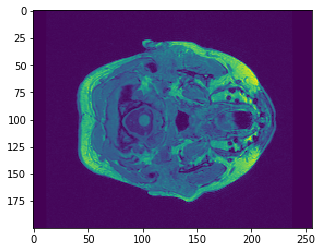

In [70]:
plt.imshow(a[:,:,100])